<a href="https://colab.research.google.com/github/rajbircit/assignments/blob/main/dl_a2/dl_assignment2_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

#### Show the environment

In [2]:
!nvidia-smi
print()
print()
print('=' * 80)
print()
print()
!df -h
print()
print()
print('=' * 80)
print()
print()
!free -m
print()
print()
print('=' * 80)
print()
print()
!lscpu
print()
print()
print('=' * 80)
print()
print()
! ps -eo pmem,pcpu,vsize,pid,cmd | sort -k 1 -nr | head -5


Thu Apr 22 15:18:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Setup logging

In [3]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import logging
import sys
import random
import matplotlib.pyplot as plt
import os
from google.colab import drive
import shutil
import zipfile
import h5py
import gc
import IPython

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

#### Mount Google Drive And Copy Files

In [4]:
drive.mount('/content/gdrive')

if (os.path.exists("/root/imagedata")):
    ret = shutil.rmtree("/root/imagedata")
os.mkdir("/root/imagedata")
shutil.copyfile( \
    "/content/gdrive/MyDrive/DeepLearningAssignment2/earth_data.zip",
    "/root/imagedata/earth_data.zip")

!cd /root/imagedata && unzip earth_data.zip && rm -f earth_data.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  earth_data.zip
  inflating: earth_data.h5           


#### Extract train and test instances

In [5]:
def loadDataH5():
    with h5py.File('/root/imagedata/earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
        return trainX, trainY, valX, valY

trainX, trainY, valX, valY = loadDataH5()
trainX = trainX / 255.0
valX = valX / 255.0

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


# Question 1 Part A

### Build a Baseline

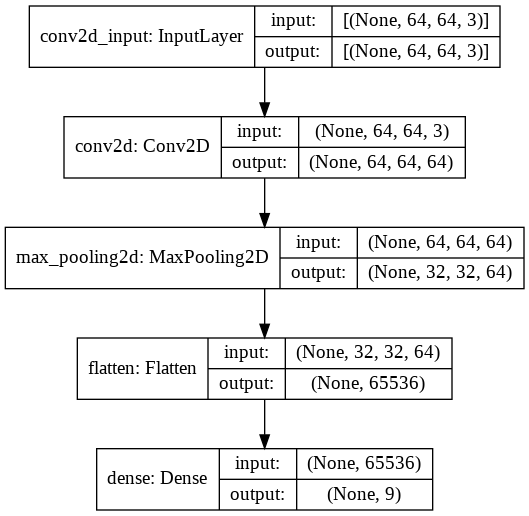

Model: "BaseLineShallowNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 9)                 589833    
Total params: 591,625
Trainable params: 591,625
Non-trainable params: 0
_________________________________________________________________
None
(19200, 64, 64, 3)
Epoch 1/15
600/600 [==============================] - 36s 6ms/step - loss: 1.5313 - accuracy: 0.4447 - val_loss: 1.1258 - val_accuracy: 0.5915
Epoch 2/15
600/600 [==============================] - 3s 5ms/step - loss:

In [6]:
class BaselineShallowNet:
    @staticmethod
    def build(inshape, nlabels):
        inputShape = trainX[0].shape
        model = tf.keras.Sequential(name="BaseLineShallowNet")
        model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', \
                  input_shape=inshape, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        plot = tf.keras.utils.plot_model(model, show_shapes=True, \
                                         expand_nested=True)
        IPython.display.display(plot)
        print(model.summary())
        return model

n_classes = len(np.unique(np.concatenate((trainY, valY))))

N_EPOCHS=15

model = BaselineShallowNet.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS)

Best validation accuracy: 0.7456250190734863, epoch = 10
Best validation loss: 0.7445400357246399, epoch = 7


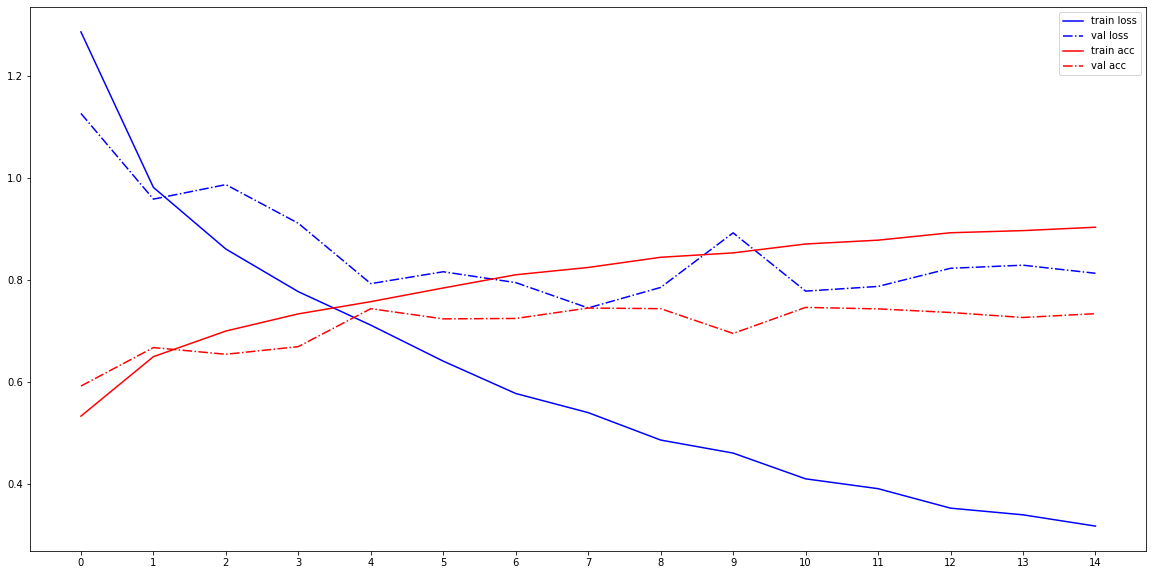

In [7]:
def plot_history(history, N_EPOCHS):
    plt.rcParams["figure.figsize"] = (20, 10)
    plt.xticks(np.arange(0, N_EPOCHS+1, 1.0))
    plt.plot(np.arange(0, N_EPOCHS), history.history["loss"], label="train loss", color='blue', linestyle='solid')
    plt.plot(np.arange(0, N_EPOCHS), history.history["val_loss"], label="val loss", color='blue', linestyle='dashdot')
    plt.plot(np.arange(0, N_EPOCHS), history.history["accuracy"], label="train acc", color='red', linestyle='solid')
    plt.plot(np.arange(0, N_EPOCHS), history.history["val_accuracy"], label="val acc", color='red', linestyle='dashdot')
    plt.legend()
    best_val_acc = max(history.history['val_accuracy'])
    index_best_val_accuracy = history.history['val_accuracy'].index(best_val_acc)
    best_val_loss = min(history.history['val_loss'])
    index_best_val_loss = history.history['val_loss'].index(best_val_loss)
    print(f"Best validation accuracy: {best_val_acc}, epoch = {index_best_val_accuracy}")
    print(f"Best validation loss: {best_val_loss}, epoch = {index_best_val_loss}")
    plt.show()
    gc.collect()

plot_history(history, N_EPOCHS)

#### Add another dense layer

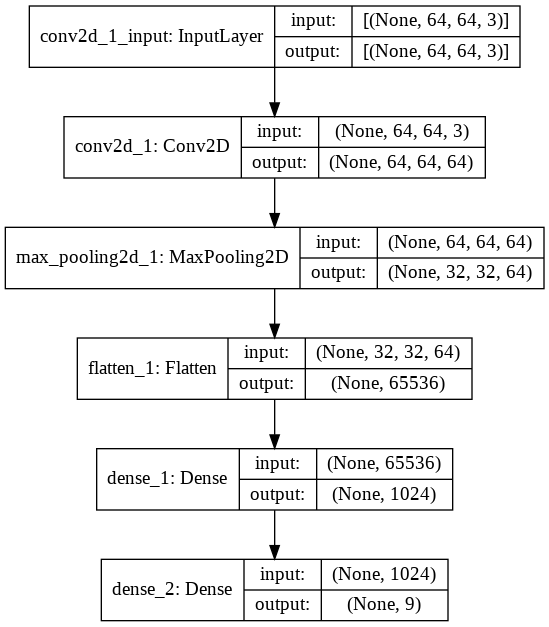

Model: "BaseLineTwoDenseLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              67109888  
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 9225      
Total params: 67,120,905
Trainable params: 67,120,905
Non-trainable params: 0
_________________________________________________________________
None
(19200, 64, 64, 3)
Epoch 1/15
600/600 [==============================] - 12s 20ms/step - loss

In [8]:
class BaselineTwoDenseLayers:
    @staticmethod
    def build(inshape, nlabels):
        inputShape = trainX[0].shape
        model = tf.keras.Sequential(name="BaseLineTwoDenseLayers")
        model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', \
                  input_shape=inshape, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(1024, activation='relu'))
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        plot = tf.keras.utils.plot_model(model, show_shapes=True, \
                                         expand_nested=True)
        IPython.display.display(plot)
        print(model.summary())
        return model

n_classes = len(np.unique(np.concatenate((trainY, valY))))

model = BaselineTwoDenseLayers.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS)

Best validation accuracy: 0.7950000166893005, epoch = 6
Best validation loss: 0.6088783740997314, epoch = 6


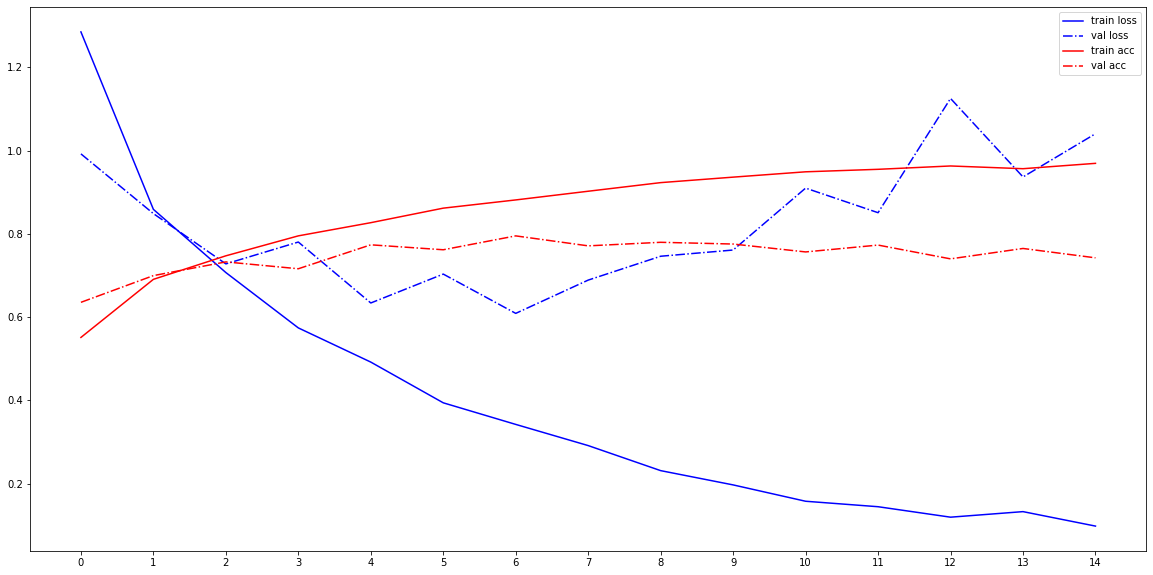

In [9]:
plot_history(history, N_EPOCHS)

#### Increase one conv layer (only one dense layer)

(64, 64, 3) 9


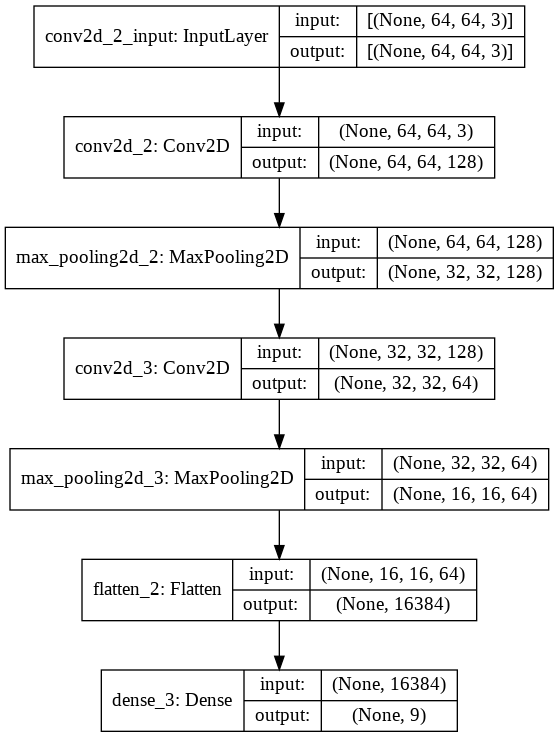

Model: "BaseLineTwoConvOneDenseLayer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 147465    
Total params: 224,841
Trainable params: 224,841
Non-trainable params: 0
________________________________

In [10]:
class BaselineTwoConvOneDenseLayers:
    @staticmethod
    def build(inshape, nlabels):
        print(inshape, nlabels)
        inputShape = trainX[0].shape
        model = tf.keras.Sequential(name="BaseLineTwoConvOneDenseLayer")
        model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', \
                  input_shape=inshape, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', \
                                         activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        plot = tf.keras.utils.plot_model(model, show_shapes=True, \
                                         expand_nested=True)
        IPython.display.display(plot)
        print(model.summary())
        return model

n_classes = len(np.unique(np.concatenate((trainY, valY))))

model = BaselineTwoConvOneDenseLayers.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS)

Best validation accuracy: 0.8245833516120911, epoch = 11
Best validation loss: 0.518493115901947, epoch = 11


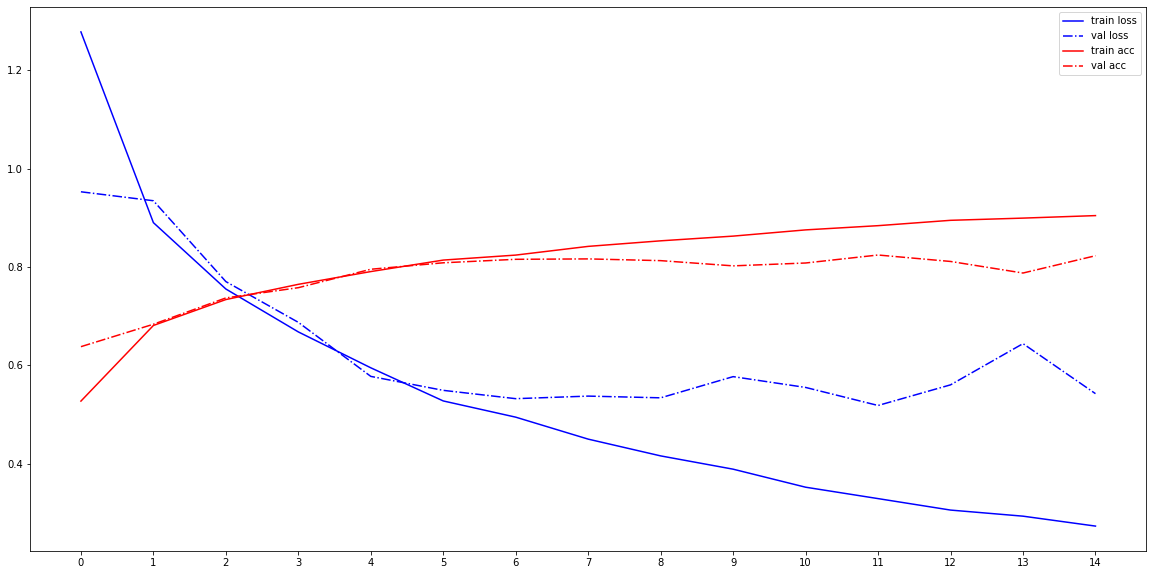

In [11]:
plot_history(history, N_EPOCHS)

In [12]:
N_EPOCHS = 20

#### Add another Dense layer (2 conv layers)

(64, 64, 3) 9


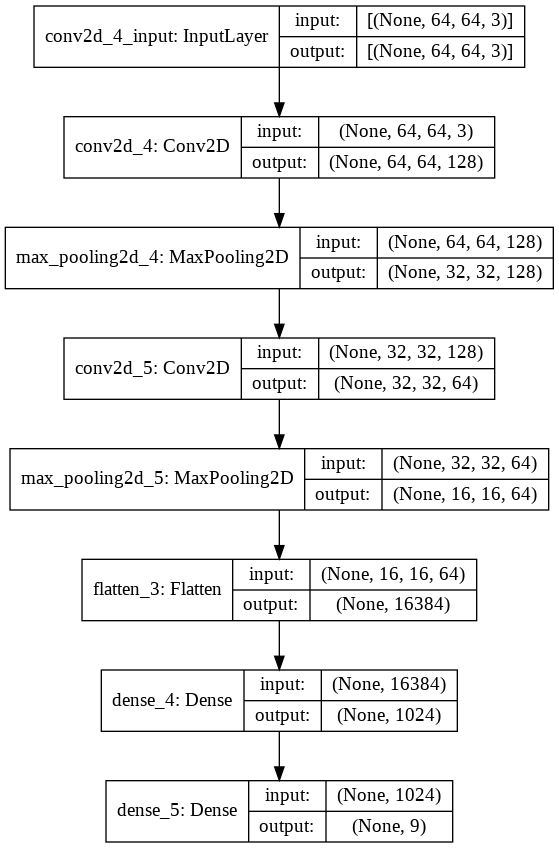

Model: "BaseLineTwoConvTwoDenseLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              16778240  
_________________________________________________________________
dense_5 (Dense)              (None, 9

In [13]:
class BaselineTwoConvTwoDenseLayers:
    @staticmethod
    def build(inshape, nlabels):
        print(inshape, nlabels)
        inputShape = trainX[0].shape
        model = tf.keras.Sequential(name="BaseLineTwoConvTwoDenseLayers")
        model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', \
                  input_shape=inshape, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', \
                                         activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(1024, activation='relu'))
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        plot = tf.keras.utils.plot_model(model, show_shapes=True, \
                                         expand_nested=True)
        IPython.display.display(plot)
        print(model.summary())
        return model

n_classes = len(np.unique(np.concatenate((trainY, valY))))

model = BaselineTwoConvTwoDenseLayers.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS)

Best validation accuracy: 0.7837499976158142, epoch = 7
Best validation loss: 0.6262969374656677, epoch = 7


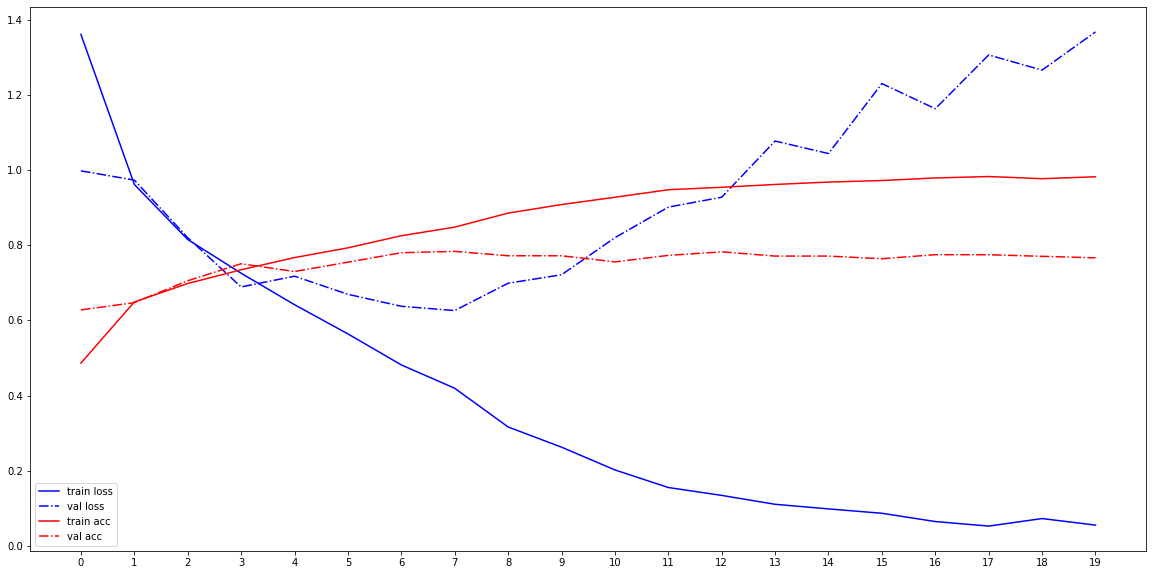

In [14]:
plot_history(history, N_EPOCHS)